In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, date
import torch
from torch import nn
import matplotlib
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LogNorm
import logging
import copy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy
import rasterio as rio
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from matplotlib import font_manager
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of .conda/envs/jianing/share/proj failed


In [2]:
# set up logging. Training logs will be stores in "./logs/training.log"
logging.basicConfig(level=logging.INFO,
                    filename="./logs/training.log",
                    format='%(asctime)s %(message)s',
                    datefmt='%m/%d/%Y %I:%M:%S %p')

In [3]:
modis_dir = "AVHRR/data/MODIS_45/"
sif_dir = "../../../sif_diurnal/OCO2_SIF"
sif_all_dir = os.path.join(sif_dir, "sif_all_day")
sif_clear_dir = os.path.join(sif_dir, "sif_clear")
sif_processed_dir = os.path.join("../../data/", "processed")
fig_dir="./figs"
hfont = {'font': Path('.conda/envs/jianing/fonts/Inter-Regular.ttf')}

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'Inter'

## 1 Preprocessing

### 1.1 Combine SIF soundings with MODIS reflectance

### 1.2 Prepare train, val, and test datasets

In [5]:
clean_files=sorted(os.listdir(sif_clear_dir))

igbp_2015=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2015001.061.2022166123617.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2015_data=igbp_2015.read()[0]
test_files_2015=[n for n in clean_files if "LtSIF_"+str(15) in n]
test_ds_2015=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in test_files_2015], dim="cell_dim")
lon_bin_2015 = test_ds_2015.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2015 = test_ds_2015.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_range=np.arange(-179.975, 180, 0.05)
lat_range=np.arange(-90, 90, 0.05)

lon_idx_2015 = np.searchsorted(lon_range, lon_bin_2015)
lat_idx_2015 = 3600 - np.searchsorted(lat_range, lat_bin_2015)
test_igbp_2015=np.zeros(test_ds_2015.Longitude.values.shape[0])
for i in range(test_ds_2015.Longitude.values.shape[0]):
    test_igbp_2015[i]=igbp_2015_data[lat_idx_2015[i]][lon_idx_2015[i]]    
test_ds_2015=test_ds_2015.assign(IGBP=xr.DataArray(test_igbp_2015, dims="cell_dim")).reset_coords()



igbp_2022=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2022001.061.2023244164746.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2022_data=igbp_2022.read()[0]
test_files_2022=[n for n in clean_files if "LtSIF_"+str(22) in n]
test_ds_2022=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in test_files_2022], dim="cell_dim")
lon_bin_2022 = test_ds_2022.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2022 = test_ds_2022.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_range=np.arange(-179.975, 180, 0.05)
lat_range=np.arange(-90, 90, 0.05)

lon_idx_2022 = np.searchsorted(lon_range, lon_bin_2022)
lat_idx_2022 = 3600 - np.searchsorted(lat_range, lat_bin_2022)
test_igbp_2022=np.zeros(test_ds_2022.Longitude.values.shape[0])
for i in range(test_ds_2022.Longitude.values.shape[0]):
    test_igbp_2022[i]=igbp_2022_data[lat_idx_2022[i]][lon_idx_2022[i]]    
test_ds_2022=test_ds_2022.assign(IGBP=xr.DataArray(test_igbp_2022, dims="cell_dim")).reset_coords()



In [6]:
igbp_2016=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2016001.061.2022168010533.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2016_data=igbp_2016.read()[0]
train_val_files_2016=[n for n in clean_files if "LtSIF_"+str(16) in n]
train_val_ds_2016=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2016], dim="cell_dim")
lon_bin_2016 = train_val_ds_2016.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2016 = train_val_ds_2016.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2016 = np.searchsorted(lon_range, lon_bin_2016)
lat_idx_2016 = 3600 - np.searchsorted(lat_range, lat_bin_2016)
train_val_igbp_2016=np.zeros(train_val_ds_2016.Longitude.values.shape[0])
for i in range(train_val_ds_2016.Longitude.values.shape[0]):
    train_val_igbp_2016[i]=igbp_2016_data[lat_idx_2016[i]][lon_idx_2016[i]]    
train_val_ds_2016=train_val_ds_2016.assign(IGBP=xr.DataArray(train_val_igbp_2016, dims="cell_dim")).reset_coords()

igbp_2017=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2017001.061.2022168170603.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2017_data=igbp_2017.read()[0]
train_val_files_2017=[n for n in clean_files if "LtSIF_"+str(17) in n]
train_val_ds_2017=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2017], dim="cell_dim")
lon_bin_2017 = train_val_ds_2017.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2017 = train_val_ds_2017.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2017 = np.searchsorted(lon_range, lon_bin_2017)
lat_idx_2017 = 3600 - np.searchsorted(lat_range, lat_bin_2017)
train_val_igbp_2017=np.zeros(train_val_ds_2017.Longitude.values.shape[0])
for i in range(train_val_ds_2017.Longitude.values.shape[0]):
    train_val_igbp_2017[i]=igbp_2017_data[lat_idx_2017[i]][lon_idx_2017[i]]    
train_val_ds_2017=train_val_ds_2017.assign(IGBP=xr.DataArray(train_val_igbp_2017, dims="cell_dim")).reset_coords()

igbp_2018=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2018001.061.2022169131657.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2018_data=igbp_2018.read()[0]
train_val_files_2018=[n for n in clean_files if "LtSIF_"+str(18) in n]
train_val_ds_2018=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2018], dim="cell_dim")
lon_bin_2018 = train_val_ds_2018.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2018 = train_val_ds_2018.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2018 = np.searchsorted(lon_range, lon_bin_2018)
lat_idx_2018 = 3600 - np.searchsorted(lat_range, lat_bin_2018)
train_val_igbp_2018=np.zeros(train_val_ds_2018.Longitude.values.shape[0])
for i in range(train_val_ds_2018.Longitude.values.shape[0]):
    train_val_igbp_2018[i]=igbp_2018_data[lat_idx_2018[i]][lon_idx_2018[i]]    
train_val_ds_2018=train_val_ds_2018.assign(IGBP=xr.DataArray(train_val_igbp_2018, dims="cell_dim")).reset_coords()

igbp_2019=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2019001.061.2022170020638.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2019_data=igbp_2019.read()[0]
train_val_files_2019=[n for n in clean_files if "LtSIF_"+str(19) in n]
train_val_ds_2019=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2019], dim="cell_dim")
lon_bin_2019 = train_val_ds_2019.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2019 = train_val_ds_2019.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2019 = np.searchsorted(lon_range, lon_bin_2019)
lat_idx_2019 = 3600 - np.searchsorted(lat_range, lat_bin_2019)
train_val_igbp_2019=np.zeros(train_val_ds_2019.Longitude.values.shape[0])
for i in range(train_val_ds_2019.Longitude.values.shape[0]):
    train_val_igbp_2019[i]=igbp_2019_data[lat_idx_2019[i]][lon_idx_2019[i]]    
train_val_ds_2019=train_val_ds_2019.assign(IGBP=xr.DataArray(train_val_igbp_2019, dims="cell_dim")).reset_coords()

igbp_2020=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2020_data=igbp_2020.read()[0]
train_val_files_2020=[n for n in clean_files if "LtSIF_"+str(20) in n]
train_val_ds_2020=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2020], dim="cell_dim")
lon_bin_2020 = train_val_ds_2020.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2020 = train_val_ds_2020.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2020 = np.searchsorted(lon_range, lon_bin_2020)
lat_idx_2020 = 3600 - np.searchsorted(lat_range, lat_bin_2020)
train_val_igbp_2020=np.zeros(train_val_ds_2020.Longitude.values.shape[0])
for i in range(train_val_ds_2020.Longitude.values.shape[0]):
    train_val_igbp_2020[i]=igbp_2020_data[lat_idx_2020[i]][lon_idx_2020[i]]    
train_val_ds_2020=train_val_ds_2020.assign(IGBP=xr.DataArray(train_val_igbp_2020, dims="cell_dim")).reset_coords()

igbp_2021=rio.open('HDF4_EOS:EOS_GRID:"../../data/MCD12C1/MCD12C1.A2021001.061.2022217040006.hdf":MOD12C1:Majority_Land_Cover_Type_1')
igbp_2021_data=igbp_2021.read()[0]
train_val_files_2021=[n for n in clean_files if "LtSIF_"+str(21) in n]
train_val_ds_2021=xr.concat([xr.open_dataset(os.path.join(sif_clear_dir, file)) for file in train_val_files_2021], dim="cell_dim")
lon_bin_2021 = train_val_ds_2021.Longitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lat_bin_2021 = train_val_ds_2021.Latitude.values.astype(np.float64) //0.05 * 0.05 + 0.025
lon_idx_2021 = np.searchsorted(lon_range, lon_bin_2021)
lat_idx_2021 = 3600 - np.searchsorted(lat_range, lat_bin_2021)
train_val_igbp_2021=np.zeros(train_val_ds_2021.Longitude.values.shape[0])
for i in range(train_val_ds_2021.Longitude.values.shape[0]):
    train_val_igbp_2021[i]=igbp_2021_data[lat_idx_2021[i]][lon_idx_2021[i]]    
train_val_ds_2021=train_val_ds_2021.assign(IGBP=xr.DataArray(train_val_igbp_2021, dims="cell_dim")).reset_coords()


combined_test_ds_with_igbp=xr.concat([train_val_ds_2016, train_val_ds_2020], dim="cell_dim")
#combined_test_ds_with_igbp=combined_test_ds_with_igbp.where(combined_test_ds_with_igbp["count"] >=8 , drop=True)
combined_test_ds_with_igbp = combined_test_ds_with_igbp.rename({"red_brdf_normalized_sza45":"Nadir_Reflectance_Band1",
           "nir_brdf_normalized_sza45":"Nadir_Reflectance_Band2",})
combined_test_ds_with_igbp = combined_test_ds_with_igbp.where(combined_test_ds_with_igbp["percent_snow"]==0, drop=True)                                                                                                           
combined_test_ds_with_igbp.to_netcdf(os.path.join(sif_processed_dir, "snow_test_with_igbp_shuffle.nc"))


train_val_with_igbp = xr.concat([test_ds_2015, train_val_ds_2017,
                                 train_val_ds_2018, train_val_ds_2019, train_val_ds_2021, test_ds_2022], dim="cell_dim")
# train_val_with_igbp=train_val_with_igbp.where(train_val_with_igbp["count"] >=8 , drop=True)
train_val_with_igbp = train_val_with_igbp.rename({"red_brdf_normalized_sza45":"Nadir_Reflectance_Band1",
           "nir_brdf_normalized_sza45":"Nadir_Reflectance_Band2",})
train_val_with_igbp = train_val_with_igbp.where(train_val_with_igbp["percent_snow"]==0, drop=True)                                                                                                           

train_val_with_igbp.to_netcdf(os.path.join(sif_processed_dir, "snow_train_val_with_igbp_shuffle.nc"))

In [7]:
train_val_ds = xr.open_dataset(os.path.join(sif_processed_dir, "snow_train_val_with_igbp_shuffle.nc"))
test_ds = xr.open_dataset(os.path.join(sif_processed_dir, "snow_test_with_igbp_shuffle.nc"))

In [8]:
train_lon_bin = train_val_ds.Longitude.values.astype(np.float64) //1 * 1 + 0.5
train_lat_bin = train_val_ds.Latitude.values.astype(np.float64) //1 * 1 + 0.5

test_lon_bin = test_ds.Longitude.values.astype(np.float64) //1 * 1 + 0.5
test_lat_bin = test_ds.Latitude.values.astype(np.float64) //1 * 1 + 0.5

lon_range=np.arange(-179.5, 180, 1)
lat_range=np.arange(-89.5, 90, 1)

train_lon_idx = np.searchsorted(lon_range, train_lon_bin)
train_lat_idx = np.searchsorted(lat_range, train_lat_bin)
test_lon_idx = np.searchsorted(lon_range, test_lon_bin)
test_lat_idx = np.searchsorted(lat_range, test_lat_bin)

In [9]:
train_density=np.zeros((180,360))
test_density=np.zeros((180,360))

for i in range(train_lon_idx.shape[0]):
    train_density[train_lat_idx[i]][train_lon_idx[i]] += 1

for i in range(test_lon_idx.shape[0]):
    test_density[test_lat_idx[i]][test_lon_idx[i]] += 1

.conda/envs/jianing/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


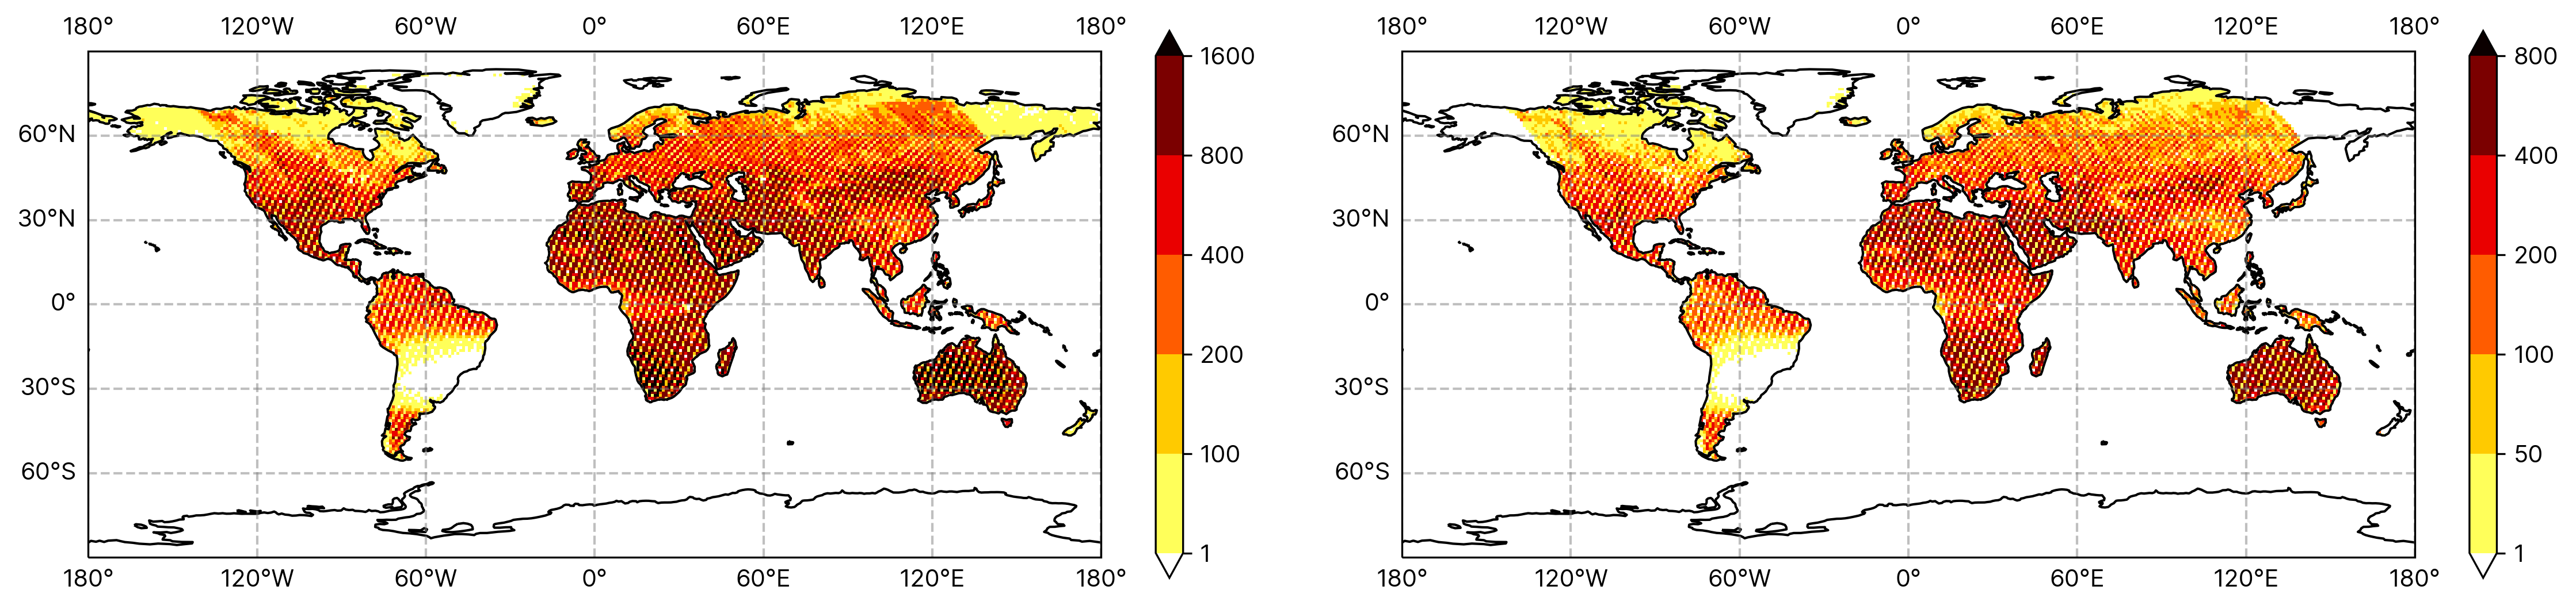

In [10]:
fig, axs=plt.subplots(1,2, figsize=(18,5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax=axs.flatten()
norm=matplotlib.colors.BoundaryNorm([1,100,200,400,800,1600], matplotlib.cm.hot.N, extend='both')
im1=ax[0].imshow(np.flip(train_density, axis=0), transform=ccrs.PlateCarree(), extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap="hot_r")
ax[0].add_feature(cartopy.feature.OCEAN, zorder=0, color="white")
ax[0].coastlines()
gl=ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right=False

fig.colorbar(im1, ax=ax[0], orientation="vertical", fraction=0.025)

norm=matplotlib.colors.BoundaryNorm([1,50,100,200,400,800], matplotlib.cm.hot.N, extend='both')
im2=ax[1].imshow(np.flip(test_density, axis=0), transform=ccrs.PlateCarree(), extent=[-180,180,-90,90], interpolation="none",  cmap="hot_r", norm=norm)
ax[1].add_feature(cartopy.feature.OCEAN, zorder=0, color="white")
ax[1].coastlines()
gl=ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right=False
cbar=fig.colorbar(im2, ax=ax[1], orientation="vertical", fraction=0.025)
plt.savefig(os.path.join(fig_dir, "snow_trainval_test_density_shuffle.pdf"), dpi=300)
plt.show()

In [11]:
ENF=1
EBF=2
DNF=3
DBF=4
MF=5
CSH=6
OSH=7
WSV=8
SVA=9
GRA=10
CRO=12

In [12]:
NF_train_val_ds = train_val_ds.where((train_val_ds.IGBP==ENF) | (train_val_ds.IGBP==DNF)).dropna(dim="cell_dim")
EBF_train_val_ds = train_val_ds.where((train_val_ds.IGBP==EBF)).dropna(dim="cell_dim")
DBF_train_val_ds = train_val_ds.where((train_val_ds.IGBP==DBF)).dropna(dim="cell_dim")
MF_train_val_ds = train_val_ds.where((train_val_ds.IGBP==MF)).dropna(dim="cell_dim")
SH_train_val_ds = train_val_ds.where((train_val_ds.IGBP==CSH) | (train_val_ds.IGBP==OSH)).dropna(dim="cell_dim")
SAV_train_val_ds = train_val_ds.where((train_val_ds.IGBP==WSV) | (train_val_ds.IGBP==SVA)).dropna(dim="cell_dim")
GRA_train_val_ds = train_val_ds.where((train_val_ds.IGBP==GRA)).dropna(dim="cell_dim")
CRO_train_val_ds = train_val_ds.where((train_val_ds.IGBP==CRO)).dropna(dim="cell_dim")

In [13]:
NF_test_ds = test_ds.where((test_ds.IGBP==ENF) | (test_ds.IGBP==DNF)).dropna(dim="cell_dim")
EBF_test_ds = test_ds.where((test_ds.IGBP==EBF)).dropna(dim="cell_dim")
DBF_test_ds = test_ds.where((test_ds.IGBP==DBF)).dropna(dim="cell_dim")
MF_test_ds = test_ds.where((test_ds.IGBP==MF)).dropna(dim="cell_dim")
SH_test_ds = test_ds.where((test_ds.IGBP==CSH) | (test_ds.IGBP==OSH)).dropna(dim="cell_dim")
SAV_test_ds = test_ds.where((test_ds.IGBP==WSV) | (test_ds.IGBP==SVA)).dropna(dim="cell_dim")
GRA_test_ds = test_ds.where((test_ds.IGBP==GRA)).dropna(dim="cell_dim")
CRO_test_ds = test_ds.where((test_ds.IGBP==CRO)).dropna(dim="cell_dim")

In [14]:
XY = np.stack([train_val_ds.Nadir_Reflectance_Band1.values,
train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(train_val_ds.SZA.values / 180 * np.pi), train_val_ds.SIF_757nm.values]).T

train_val_idx = train_val_ds.cell_dim.values
np.random.shuffle(train_val_idx)
XY = XY[train_val_idx, :]

# normalization of features
scaler = StandardScaler()
scaler.fit(XY[:,0:3])

StandardScaler()

In [15]:
NF_XY_train_val = np.stack([NF_train_val_ds.Nadir_Reflectance_Band1.values,
NF_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(NF_train_val_ds.SZA.values / 180 * np.pi), NF_train_val_ds.SIF_757nm.values]).T
NF_train_val_ar_x = scaler.transform(NF_XY_train_val[:, 0:3])
NF_train_val_ar_y = NF_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "NF_train_val_ar_x_snow_shuffle.npy"), NF_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "NF_train_val_ar_y_snow_shuffle.npy"), NF_train_val_ar_y)


EBF_XY_train_val = np.stack([EBF_train_val_ds.Nadir_Reflectance_Band1.values,
EBF_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(EBF_train_val_ds.SZA.values / 180 * np.pi), EBF_train_val_ds.SIF_757nm.values]).T
EBF_train_val_ar_x = scaler.transform(EBF_XY_train_val[:, 0:3])
EBF_train_val_ar_y = EBF_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "EBF_train_val_ar_x_snow_shuffle.npy"), EBF_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "EBF_train_val_ar_y_snow_shuffle.npy"), EBF_train_val_ar_y)

DBF_XY_train_val = np.stack([DBF_train_val_ds.Nadir_Reflectance_Band1.values,
DBF_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(DBF_train_val_ds.SZA.values / 180 * np.pi), DBF_train_val_ds.SIF_757nm.values]).T
DBF_train_val_ar_x = scaler.transform(DBF_XY_train_val[:, 0:3])
DBF_train_val_ar_y = DBF_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "DBF_train_val_ar_x_snow_shuffle.npy"), DBF_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "DBF_train_val_ar_y_snow_shuffle.npy"), DBF_train_val_ar_y)

MF_XY_train_val = np.stack([MF_train_val_ds.Nadir_Reflectance_Band1.values,
MF_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(MF_train_val_ds.SZA.values / 180 * np.pi), MF_train_val_ds.SIF_757nm.values]).T
MF_train_val_ar_x = scaler.transform(MF_XY_train_val[:, 0:3])
MF_train_val_ar_y = MF_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "MF_train_val_ar_x_snow_shuffle.npy"), MF_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "MF_train_val_ar_y_snow_shuffle.npy"), MF_train_val_ar_y)

SH_XY_train_val = np.stack([SH_train_val_ds.Nadir_Reflectance_Band1.values,
SH_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(SH_train_val_ds.SZA.values / 180 * np.pi), SH_train_val_ds.SIF_757nm.values]).T
SH_train_val_ar_x = scaler.transform(SH_XY_train_val[:, 0:3])
SH_train_val_ar_y = SH_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "SH_train_val_ar_x_snow_shuffle.npy"), SH_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "SH_train_val_ar_y_snow_shuffle.npy"), SH_train_val_ar_y)

SAV_XY_train_val = np.stack([SAV_train_val_ds.Nadir_Reflectance_Band1.values,
SAV_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(SAV_train_val_ds.SZA.values / 180 * np.pi), SAV_train_val_ds.SIF_757nm.values]).T
SAV_train_val_ar_x = scaler.transform(SAV_XY_train_val[:, 0:3])
SAV_train_val_ar_y = SAV_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "SAV_train_val_ar_x_snow_shuffle.npy"), SAV_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "SAV_train_val_ar_y_snow_shuffle.npy"), SAV_train_val_ar_y)

GRA_XY_train_val = np.stack([GRA_train_val_ds.Nadir_Reflectance_Band1.values,
GRA_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(GRA_train_val_ds.SZA.values / 180 * np.pi), GRA_train_val_ds.SIF_757nm.values]).T
GRA_train_val_ar_x = scaler.transform(GRA_XY_train_val[:, 0:3])
GRA_train_val_ar_y = GRA_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "GRA_train_val_ar_x_snow_shuffle.npy"), GRA_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "GRA_train_val_ar_y_snow_shuffle.npy"), GRA_train_val_ar_y)

CRO_XY_train_val = np.stack([CRO_train_val_ds.Nadir_Reflectance_Band1.values,
CRO_train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(CRO_train_val_ds.SZA.values / 180 * np.pi), CRO_train_val_ds.SIF_757nm.values]).T
CRO_train_val_ar_x = scaler.transform(CRO_XY_train_val[:, 0:3])
CRO_train_val_ar_y = CRO_XY_train_val[:, 3]
np.save(os.path.join(sif_processed_dir, "CRO_train_val_ar_x_snow_shuffle.npy"), CRO_train_val_ar_x)
np.save(os.path.join(sif_processed_dir, "CRO_train_val_ar_y_snow_shuffle.npy"), CRO_train_val_ar_y)

In [16]:
NF_XY_test = np.stack([NF_test_ds.Nadir_Reflectance_Band1.values,
NF_test_ds.Nadir_Reflectance_Band2.values,
np.cos(NF_test_ds.SZA.values / 180 * np.pi), NF_test_ds.SIF_757nm.values]).T
NF_test_ar_x = scaler.transform(NF_XY_test[:, 0:3])
NF_test_ar_y = NF_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "NF_test_ar_x_snow_shuffle.npy"), NF_test_ar_x)
np.save(os.path.join(sif_processed_dir, "NF_test_ar_y_snow_shuffle.npy"), NF_test_ar_y)


EBF_XY_test = np.stack([EBF_test_ds.Nadir_Reflectance_Band1.values,
EBF_test_ds.Nadir_Reflectance_Band2.values,
np.cos(EBF_test_ds.SZA.values / 180 * np.pi), EBF_test_ds.SIF_757nm.values]).T
EBF_test_ar_x = scaler.transform(EBF_XY_test[:, 0:3])
EBF_test_ar_y = EBF_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "EBF_test_ar_x_snow_shuffle.npy"), EBF_test_ar_x)
np.save(os.path.join(sif_processed_dir, "EBF_test_ar_y_snow_shuffle.npy"), EBF_test_ar_y)

DBF_XY_test = np.stack([DBF_test_ds.Nadir_Reflectance_Band1.values,
DBF_test_ds.Nadir_Reflectance_Band2.values,
np.cos(DBF_test_ds.SZA.values / 180 * np.pi), DBF_test_ds.SIF_757nm.values]).T
DBF_test_ar_x = scaler.transform(DBF_XY_test[:, 0:3])
DBF_test_ar_y = DBF_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "DBF_test_ar_x_snow_shuffle.npy"), DBF_test_ar_x)
np.save(os.path.join(sif_processed_dir, "DBF_test_ar_y_snow_shuffle.npy"), DBF_test_ar_y)

MF_XY_test = np.stack([MF_test_ds.Nadir_Reflectance_Band1.values,
MF_test_ds.Nadir_Reflectance_Band2.values,
np.cos(MF_test_ds.SZA.values / 180 * np.pi), MF_test_ds.SIF_757nm.values]).T
MF_test_ar_x = scaler.transform(MF_XY_test[:, 0:3])
MF_test_ar_y = MF_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "MF_test_ar_x_snow_shuffle.npy"), MF_test_ar_x)
np.save(os.path.join(sif_processed_dir, "MF_test_ar_y_snow_shuffle.npy"), MF_test_ar_y)

SH_XY_test = np.stack([SH_test_ds.Nadir_Reflectance_Band1.values,
SH_test_ds.Nadir_Reflectance_Band2.values,
np.cos(SH_test_ds.SZA.values / 180 * np.pi), SH_test_ds.SIF_757nm.values]).T
SH_test_ar_x = scaler.transform(SH_XY_test[:, 0:3])
SH_test_ar_y = SH_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "SH_test_ar_x_snow_shuffle.npy"), SH_test_ar_x)
np.save(os.path.join(sif_processed_dir, "SH_test_ar_y_snow_shuffle.npy"), SH_test_ar_y)

SAV_XY_test = np.stack([SAV_test_ds.Nadir_Reflectance_Band1.values,
SAV_test_ds.Nadir_Reflectance_Band2.values,
np.cos(SAV_test_ds.SZA.values / 180 * np.pi), SAV_test_ds.SIF_757nm.values]).T
SAV_test_ar_x = scaler.transform(SAV_XY_test[:, 0:3])
SAV_test_ar_y = SAV_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "SAV_test_ar_x_snow_shuffle.npy"), SAV_test_ar_x)
np.save(os.path.join(sif_processed_dir, "SAV_test_ar_y_snow_shuffle.npy"), SAV_test_ar_y)

GRA_XY_test = np.stack([GRA_test_ds.Nadir_Reflectance_Band1.values,
GRA_test_ds.Nadir_Reflectance_Band2.values,
np.cos(GRA_test_ds.SZA.values / 180 * np.pi), GRA_test_ds.SIF_757nm.values]).T
GRA_test_ar_x = scaler.transform(GRA_XY_test[:, 0:3])
GRA_test_ar_y = GRA_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "GRA_test_ar_x_snow_shuffle.npy"), GRA_test_ar_x)
np.save(os.path.join(sif_processed_dir, "GRA_test_ar_y_snow_shuffle.npy"), GRA_test_ar_y)

CRO_XY_test = np.stack([CRO_test_ds.Nadir_Reflectance_Band1.values,
CRO_test_ds.Nadir_Reflectance_Band2.values,
np.cos(CRO_test_ds.SZA.values / 180 * np.pi), CRO_test_ds.SIF_757nm.values]).T
CRO_test_ar_x = scaler.transform(CRO_XY_test[:, 0:3])
CRO_test_ar_y = CRO_XY_test[:, 3]
np.save(os.path.join(sif_processed_dir, "CRO_test_ar_x_snow_shuffle.npy"), CRO_test_ar_x)
np.save(os.path.join(sif_processed_dir, "CRO_test_ar_y_snow_shuffle.npy"), CRO_test_ar_y)

In [17]:
# construct feature and target arrays
XY = np.stack([train_val_ds.Nadir_Reflectance_Band1.values,
train_val_ds.Nadir_Reflectance_Band2.values,
np.cos(train_val_ds.SZA.values / 180 * np.pi), train_val_ds.SIF_757nm.values]).T

train_val_idx = train_val_ds.cell_dim.values
np.random.shuffle(train_val_idx)
XY = XY[train_val_idx, :]

# normalization of features
scaler = StandardScaler()
scaler.fit(XY[:,0:3])

# split train and val
X = scaler.transform(XY[:,0:3])
Y = XY[:, 3]
train_ar_x = X[0:int(XY.shape[0] * 0.8), :]
train_ar_y = Y[0:int(XY.shape[0] * 0.8)]
val_ar_x = X[int(XY.shape[0] * 0.8):, :]
val_ar_y = Y[int(XY.shape[0] * 0.8):]

# prepare test dataset, normalize its features
XY_test = np.stack([test_ds.Nadir_Reflectance_Band1.values,
test_ds.Nadir_Reflectance_Band2.values,
np.cos(test_ds.SZA.values / 180 * np.pi), test_ds.SIF_757nm.values]).T

test_ar_x = scaler.transform(XY_test[:, 0:3])
test_ar_y = XY_test[:, 3]

In [18]:
# save the arrays to file, commented out to avoid overwrite
np.save(os.path.join(sif_processed_dir, "train_arr_x_snow_shuffle.npy"), train_ar_x)
np.save(os.path.join(sif_processed_dir, "train_arr_y_snow_shuffle.npy"), train_ar_y)
np.save(os.path.join(sif_processed_dir, "val_arr_x_snow_shuffle.npy"), val_ar_x)
np.save(os.path.join(sif_processed_dir, "val_arr_y_snow_shuffle.npy"), val_ar_y)
np.save(os.path.join(sif_processed_dir, "test_arr_x_snow_shuffle.npy"), test_ar_x)
np.save(os.path.join(sif_processed_dir, "test_arr_y_snow_shuffle.npy"), test_ar_y)

In [19]:
np.save(os.path.join(sif_processed_dir, "train_val_idx_snow_shuffle.npy"), train_val_idx)

## 2 Training Models

In [20]:
train_ar_x = np.load(os.path.join(sif_processed_dir, "train_arr_x_snow_shuffle.npy"))
train_ar_y = np.load(os.path.join(sif_processed_dir, "train_arr_y_snow_shuffle.npy"))
val_ar_x = np.load(os.path.join(sif_processed_dir, "val_arr_x_snow_shuffle.npy"))
val_ar_y = np.load(os.path.join(sif_processed_dir, "val_arr_y_snow_shuffle.npy"))
test_ar_x = np.load(os.path.join(sif_processed_dir, "test_arr_x_snow_shuffle.npy"))
test_ar_y = np.load(os.path.join(sif_processed_dir, "test_arr_y_snow_shuffle.npy"))

In [21]:
len(train_ar_y) + len(val_ar_y)

6625696

In [22]:
len(test_ar_y)

2283608

In [23]:
class SIFDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float().to(device = try_gpu())  
        self.y = torch.tensor(y).float().to(device = try_gpu())  
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [24]:
def try_gpu(i=0): 
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

# feedforward model construct function
def construct_model(input_dim, hidden_dim, n_hidden_layers, drop_out=None):
    layers=[]
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.ReLU())
    if drop_out:
        layers.append(nn.Dropout(p=0.2))
    for i in range(n_hidden_layers - 1):
        layers.append(nn.Linear(hidden_dim,hidden_dim))
        layers.append(nn.ReLU())
        if drop_out:
            layers.append(nn.Dropout(p=drop_out))
    layers.append(nn.Linear(hidden_dim, 1))
    return nn.Sequential(*layers).to(device=try_gpu())

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.001)

In [25]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    loss_sum=0
    sample_sum=0
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        loss_sum += l.sum()
        sample_sum += l.numel()
    return loss_sum / sample_sum

In [29]:
def train(layers, hidden_dims, lrs, bs, num_epochs, train_dataset, val_dataset=None, PATIENCE=10):
    logging.info("layers: "+ str(layers))
    logging.info("hidden_dims: "+ str(hidden_dims))
    logging.info("lrs: "+ str(lrs))
    logging.info("bs: "+ str(bs))

    best_overall=9999999999999
    best_model=None
    if val_dataset == None:
        for lr in lrs:
            for n_hidden_layers in layers:
                for hidden_dim in hidden_dims:
                    net= construct_model(3, hidden_dim, n_hidden_layers)
                    for batch_size in bs:
                        net.apply(init_weights);
                        train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        loss = nn.MSELoss()
                        trainer = torch.optim.Adam(net.parameters(), lr=lr)
                        best_loss = 9999999999999
                        finished=False
                        no_improvement = 0
                        best_model_param = None
                        for epoch in range(num_epochs):
                            for X, y in train_iter:
                                l = loss(net(X).squeeze(), y)
                                trainer.zero_grad()
                                l.backward()
                                trainer.step()
                            if epoch == 0 or (epoch + 1) % 1 == 0:
                                with torch.no_grad():
                                    train_loss = evaluate_loss(net, train_iter, loss)
                                    logging.info(" epoch: " + str(epoch + 1) + " train: " + str(train_loss))
                        timestring = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
                        best_model_param = copy.deepcopy(net.state_dict())
                        best_model = net
                        torch.save(best_model_param, "./models/"+ "snow_shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size))
                        logging.info("./models/"+ "snow_shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size) + " completed. "+ " epoch: " + str(epoch + 1) + " train: " + str(train_loss))
    else:
        for lr in lrs:
            for n_hidden_layers in layers:
                for hidden_dim in hidden_dims:
                    net= construct_model(3, hidden_dim, n_hidden_layers)
                    for batch_size in bs:
                        net.apply(init_weights);
                        train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                        loss = nn.MSELoss()
                        trainer = torch.optim.Adam(net.parameters(), lr=lr)
                        best_loss = 9999999999999
                        finished=False
                        no_improvement = 0
                        best_model_param = None
                        for epoch in range(num_epochs):
                            for X, y in train_iter:
                                l = loss(net(X).squeeze(), y)
                                trainer.zero_grad()
                                l.backward()
                                trainer.step()
                            if epoch == 0 or (epoch + 1) % 1 == 0:
                                with torch.no_grad():
                                    train_loss = evaluate_loss(net, train_iter, loss)
                                    val_loss = evaluate_loss(net, val_iter, loss)
                                    logging.info(" epoch: " + str(epoch + 1) + " train: " + str(train_loss) + " val: " + str(val_loss))
                                    if val_loss < best_loss:
                                        no_improvement = 0
                                        best_loss = val_loss
                                        best_model_param = copy.deepcopy(net.state_dict())
                                        if val_loss < best_overall:
                                            best_overall=val_loss
                                            if best_model != net:
                                                best_model=net
                                                logging.info("NEW BEST MODEL " + str(net))
                                    if val_loss > best_loss:
                                        no_improvement = no_improvement + 1
                                        if no_improvement > PATIENCE:
                                            timestring = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
                                            torch.save(best_model_param, "./models/"+  "snow_shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size))
                                            logging.info("./models/"+ "snow_shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size) + " completed. "+  " epoch: " + str(epoch + 1) + " train: " + str(train_loss) + " best val: " + str(best_loss))
                                            logging.info("finish time: "+ timestring)
                                            finished = True
                                            break
                        if not finished:
                            timestring = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
                            torch.save(best_model_param, "./models/"+ "shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size))
                            logging.info("./models/"+ "snow_shuffle_layer_" + str(n_hidden_layers) + "_neuron_" + str(hidden_dim) + "_"  + timestring + "_lr" + str(lr) +"_batchsize" + str(batch_size) + " completed. "+ " epoch: " + str(epoch + 1) + " train: " + str(train_loss) + " best val: " + str(best_loss))
        logging.info(best_overall)
    return best_model

In [27]:
#lrs = [1e-3, 5e-4]
#bs = [1024]
#layers = [1, 2, 3]
#hidden_dims = [8, 32, 64]
#num_epochs = 40

lrs = [1e-3,]
bs = [1024]
layers = [3,]
hidden_dims = [64,]
num_epochs = 40
train_ds = SIFDataset(train_ar_x, train_ar_y)
val_ds = SIFDataset(val_ar_x, val_ar_y)
train(layers, hidden_dims, lrs, bs, num_epochs, train_ds, val_ds, PATIENCE=10)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
)

### Retrain with combined train and val dataset

In [27]:
train_val_ar_x = np.vstack([train_ar_x, val_ar_x])
train_val_ar_y = np.hstack([train_ar_y, val_ar_y])

In [30]:
lrs = [1e-3,]
bs = [1024]
layers = [2,]
hidden_dims = [64,]
num_epochs = 40
train_val_dataset = SIFDataset(train_val_ar_x, train_val_ar_y)
train(layers, hidden_dims, lrs, bs, num_epochs, train_val_dataset, PATIENCE=10)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

## 3 Evaluate Model Performance

In [31]:
# load the train, val, and test datasets
train_ar_x = np.load(os.path.join(sif_processed_dir, "train_arr_x_snow_shuffle.npy"))
train_ar_y = np.load(os.path.join(sif_processed_dir, "train_arr_y_snow_shuffle.npy"))
val_ar_x = np.load(os.path.join(sif_processed_dir, "val_arr_x_snow_shuffle.npy"))
val_ar_y = np.load(os.path.join(sif_processed_dir, "val_arr_y_snow_shuffle.npy"))
train_val_ar_x = np.vstack([train_ar_x, val_ar_x])
train_val_ar_y = np.hstack([train_ar_y, val_ar_y])
test_ar_x = np.load(os.path.join(sif_processed_dir, "test_arr_x_snow_shuffle.npy"))
test_ar_y = np.load(os.path.join(sif_processed_dir, "test_arr_y_snow_shuffle.npy"))

In [32]:
NF_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "NF_train_val_ar_x_snow_shuffle.npy"))
NF_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "NF_train_val_ar_y_snow_shuffle.npy"))
EBF_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "EBF_train_val_ar_x_snow_shuffle.npy"))
EBF_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "EBF_train_val_ar_y_snow_shuffle.npy"))
DBF_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "DBF_train_val_ar_x_snow_shuffle.npy"))
DBF_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "DBF_train_val_ar_y_snow_shuffle.npy"))
MF_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "MF_train_val_ar_x_snow_shuffle.npy"))
MF_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "MF_train_val_ar_y_snow_shuffle.npy"))
SH_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "SH_train_val_ar_x_snow_shuffle.npy"))
SH_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "SH_train_val_ar_y_snow_shuffle.npy"))
SAV_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "SAV_train_val_ar_x_snow_shuffle.npy"))
SAV_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "SAV_train_val_ar_y_snow_shuffle.npy"))
GRA_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "GRA_train_val_ar_x_snow_shuffle.npy"))
GRA_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "GRA_train_val_ar_y_snow_shuffle.npy"))
CRO_train_val_ar_x = np.load(os.path.join(sif_processed_dir, "CRO_train_val_ar_x_snow_shuffle.npy"))
CRO_train_val_ar_y = np.load(os.path.join(sif_processed_dir, "CRO_train_val_ar_y_snow_shuffle.npy"))

NF_test_ar_x = np.load(os.path.join(sif_processed_dir, "NF_test_ar_x_snow_shuffle.npy"))
NF_test_ar_y = np.load(os.path.join(sif_processed_dir, "NF_test_ar_y_snow_shuffle.npy"))
EBF_test_ar_x = np.load(os.path.join(sif_processed_dir, "EBF_test_ar_x_snow_shuffle.npy"))
EBF_test_ar_y = np.load(os.path.join(sif_processed_dir, "EBF_test_ar_y_snow_shuffle.npy"))
DBF_test_ar_x = np.load(os.path.join(sif_processed_dir, "DBF_test_ar_x_snow_shuffle.npy"))
DBF_test_ar_y = np.load(os.path.join(sif_processed_dir, "DBF_test_ar_y_snow_shuffle.npy"))
MF_test_ar_x = np.load(os.path.join(sif_processed_dir, "MF_test_ar_x_snow_shuffle.npy"))
MF_test_ar_y = np.load(os.path.join(sif_processed_dir, "MF_test_ar_y_snow_shuffle.npy"))
SH_test_ar_x = np.load(os.path.join(sif_processed_dir, "SH_test_ar_x_snow_shuffle.npy"))
SH_test_ar_y = np.load(os.path.join(sif_processed_dir, "SH_test_ar_y_snow_shuffle.npy"))
SAV_test_ar_x = np.load(os.path.join(sif_processed_dir, "SAV_test_ar_x_snow_shuffle.npy"))
SAV_test_ar_y = np.load(os.path.join(sif_processed_dir, "SAV_test_ar_y_snow_shuffle.npy"))
GRA_test_ar_x = np.load(os.path.join(sif_processed_dir, "GRA_test_ar_x_snow_shuffle.npy"))
GRA_test_ar_y = np.load(os.path.join(sif_processed_dir, "GRA_test_ar_y_snow_shuffle.npy"))
CRO_test_ar_x = np.load(os.path.join(sif_processed_dir, "CRO_test_ar_x_snow_shuffle.npy"))
CRO_test_ar_y = np.load(os.path.join(sif_processed_dir, "CRO_test_ar_y_snow_shuffle.npy"))

In [33]:
net = construct_model(3, 64, 2);
model_name="snow_shuffle_layer_2_neuron_64_10-11-2023_10-20-18_lr0.001_batchsize1024"
model_dir="./models"
net.load_state_dict(torch.load(os.path.join(model_dir, model_name), map_location=torch.device('cpu')))
net.eval();

In [34]:
with torch.no_grad():
    predicted_test=net(torch.tensor(test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    predicted_train_val=net(torch.tensor(train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    NF_train_val_predicted = net(torch.tensor(NF_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    EBF_train_val_predicted = net(torch.tensor(EBF_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    DBF_train_val_predicted = net(torch.tensor(DBF_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    MF_train_val_predicted = net(torch.tensor(MF_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    SH_train_val_predicted = net(torch.tensor(SH_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    SAV_train_val_predicted = net(torch.tensor(SAV_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    GRA_train_val_predicted = net(torch.tensor(GRA_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    CRO_train_val_predicted = net(torch.tensor(CRO_train_val_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()

    NF_test_predicted = net(torch.tensor(NF_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    EBF_test_predicted = net(torch.tensor(EBF_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    DBF_test_predicted = net(torch.tensor(DBF_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    MF_test_predicted = net(torch.tensor(MF_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    SH_test_predicted = net(torch.tensor(SH_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    SAV_test_predicted = net(torch.tensor(SAV_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    GRA_test_predicted = net(torch.tensor(GRA_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()
    CRO_test_predicted = net(torch.tensor(CRO_test_ar_x[:, 0:3]).float().to(try_gpu())).cpu().numpy().squeeze()


In [35]:
def evaluate_performance(true, predicted, ax, IGBP_name=None):
    res = linregress(predicted, true)
    #histogram definition
    bins = [100, 100] # number of bins

    # histogram the data
    hh, locx, locy = np.histogram2d(predicted, true, bins=bins)

    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(predicted,true)])
    idx = z.argsort()
    x2, y2, z2 = predicted[idx], true[idx], z[idx]

    s = ax.scatter(x2, y2, c=z2, cmap='jet', marker='.')
    axis_min=min(predicted.min(), true.min())*1.1
    axis_max=max(predicted.max(), true.max())*1.1    
    ax.plot(np.arange(-10, 10), np.arange(-10, 10), "k--")
    ax.plot(predicted, res.intercept + res.slope*predicted, 'red', label='fitted line')
    ax.set_xticks(np.arange(np.floor(axis_min)+1, np.ceil(axis_max), 1))
    ax.set_yticks(np.arange(np.floor(axis_min)+1, np.ceil(axis_max), 1))
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_box_aspect(1)
    ax.text(0.15, 0.85, IGBP_name,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=14, **hfont)
    ax.tick_params(direction="in")
    metric_dict=dict()
    metric_dict["r2"]=r2_score(true, predicted)
    metric_dict["mse"]=mean_squared_error(true, predicted, squared=False)
    metric_dict["mae"]=mean_absolute_error(true, predicted)
    
    ax.text(0.95, 0.19, 'N={0:.{1}f}'.format(true.shape[0], 0),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=12, **hfont)
    ax.text(0.95, 0.12, '$R^2$: {0:.{1}f}'.format(metric_dict["r2"], 2),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=12, **hfont)
    ax.text(0.95, 0.05, 'RMSE: {0:.{1}f}'.format(metric_dict["mse"], 2),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=12, **hfont)

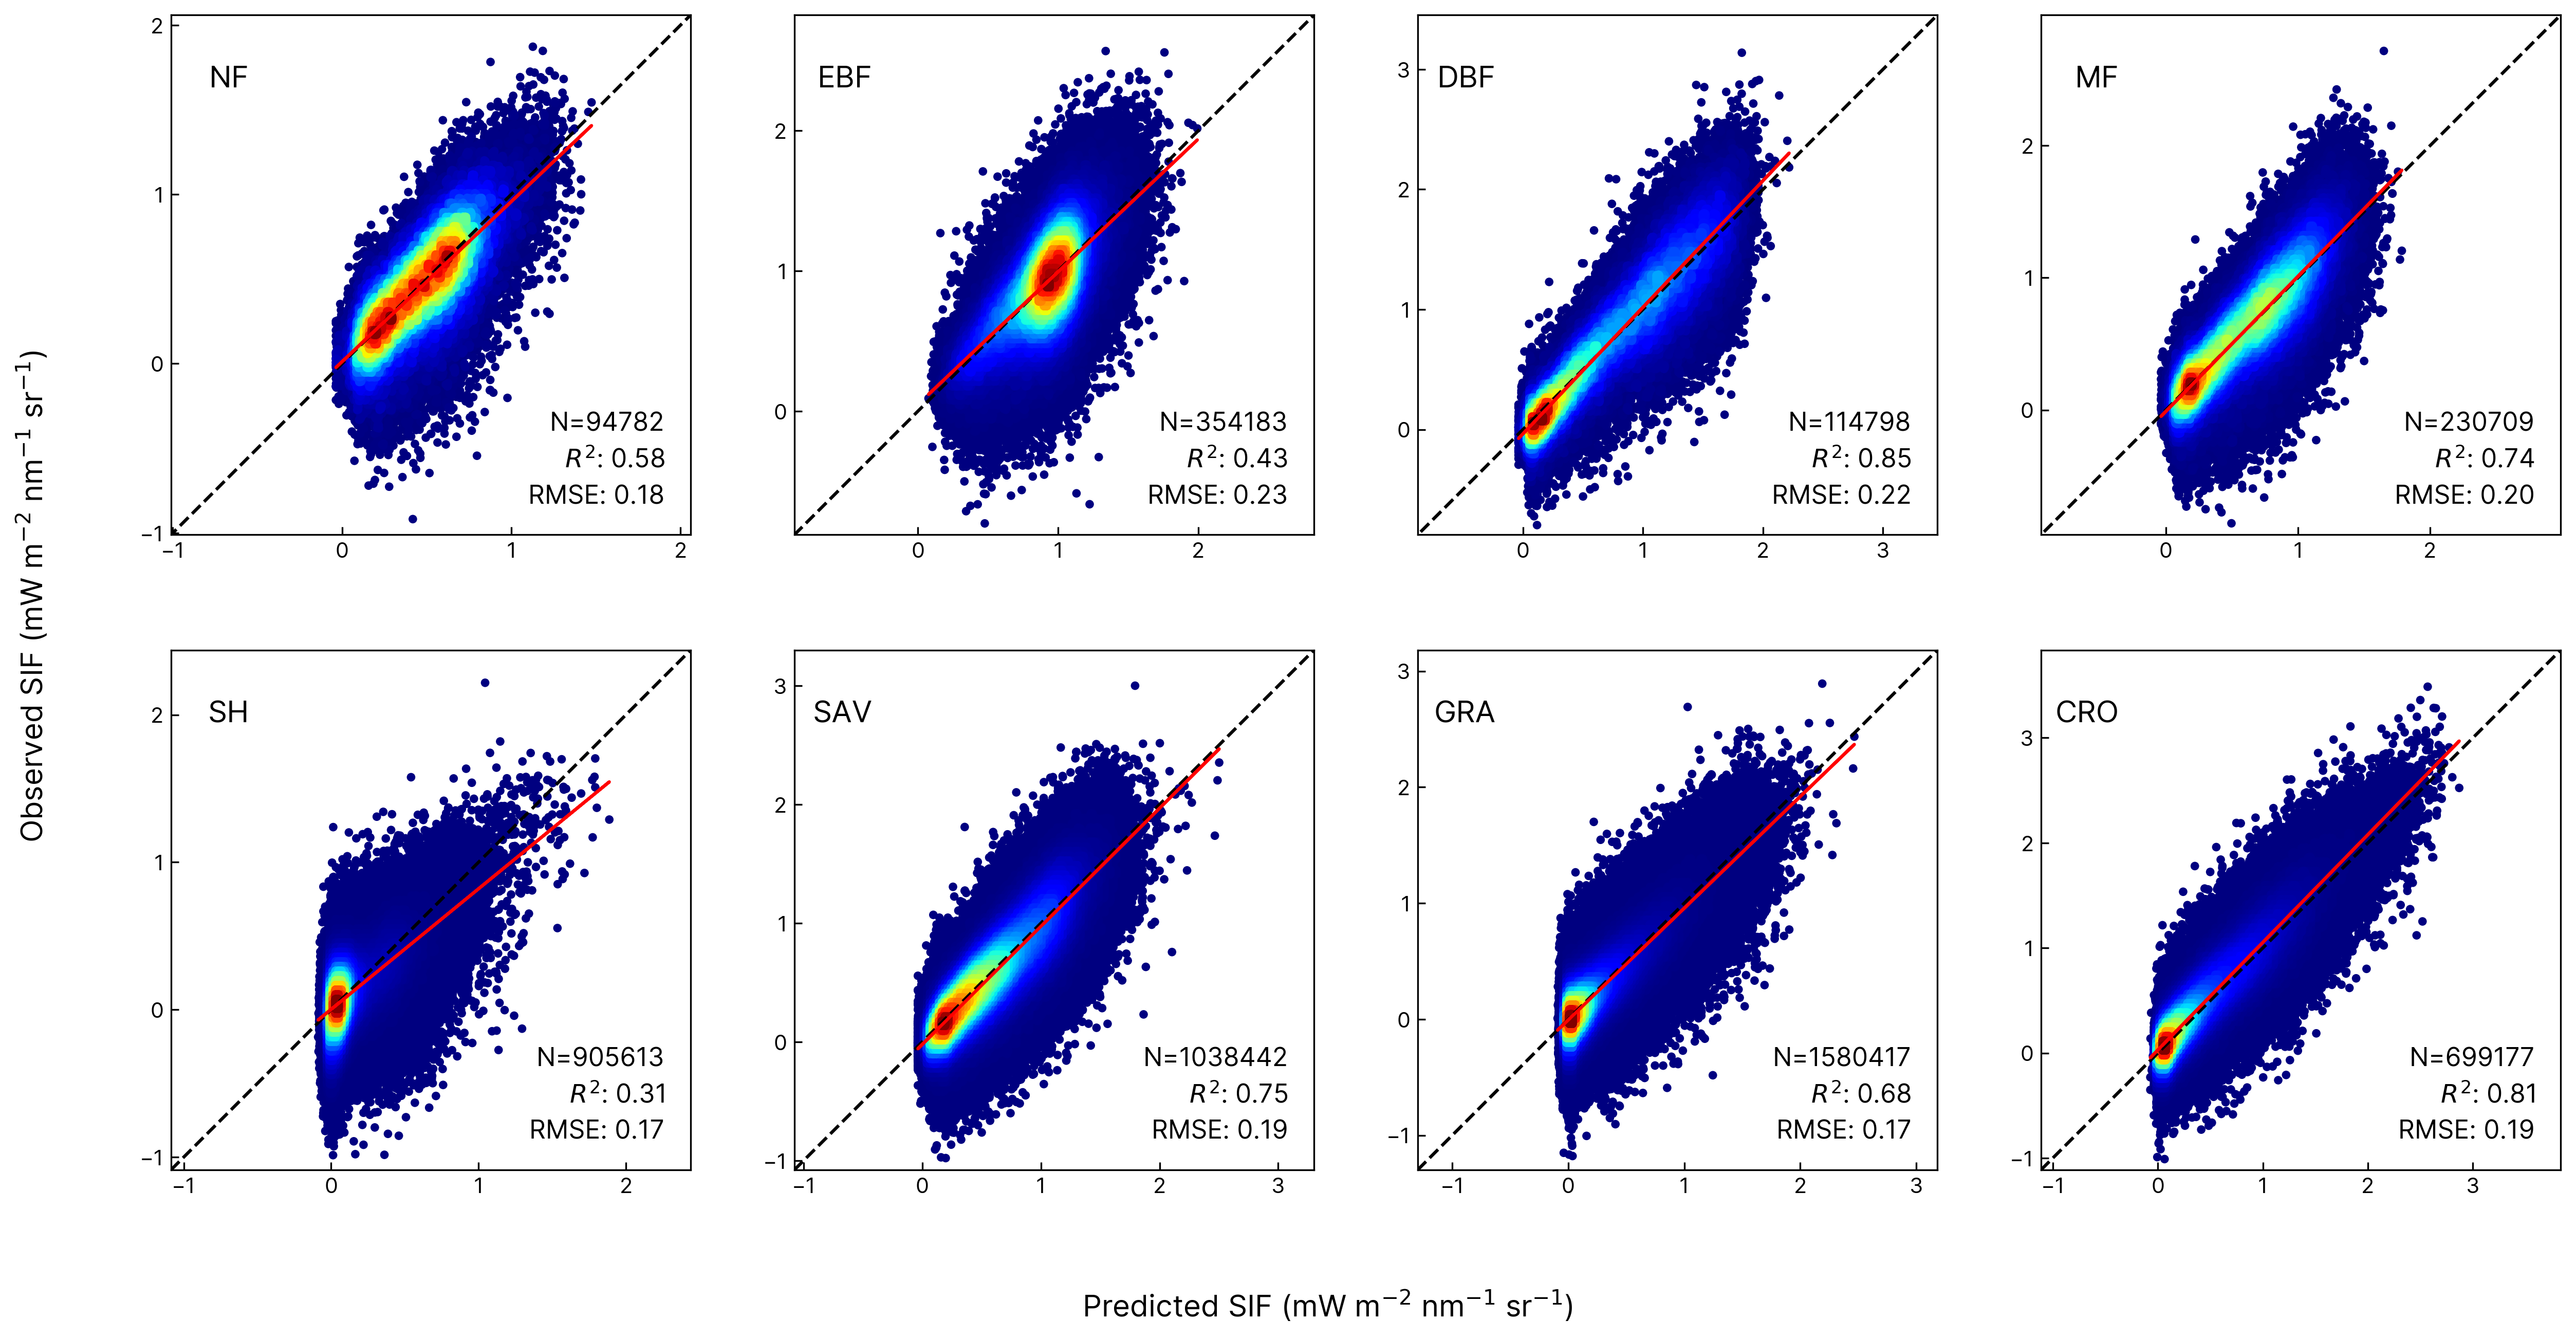

In [36]:
fig, axs=plt.subplots(2,4, figsize=(20,10), dpi=300)

ax=axs.flatten()
evaluate_performance(NF_train_val_ar_y, NF_train_val_predicted, ax[0], "NF")
evaluate_performance(EBF_train_val_ar_y, EBF_train_val_predicted, ax[1], "EBF")
evaluate_performance(DBF_train_val_ar_y, DBF_train_val_predicted, ax[2], "DBF")
evaluate_performance(MF_train_val_ar_y, MF_train_val_predicted, ax[3], "MF")
evaluate_performance(SH_train_val_ar_y, SH_train_val_predicted, ax[4], "SH")
evaluate_performance(SAV_train_val_ar_y, SAV_train_val_predicted, ax[5], "SAV")
evaluate_performance(GRA_train_val_ar_y, GRA_train_val_predicted, ax[6], "GRA")
evaluate_performance(CRO_train_val_ar_y, CRO_train_val_predicted, ax[7], "CRO")

fig.text(0.5, 0.04, 'Predicted SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, 'Observed SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig(os.path.join(fig_dir, model_name + "_train_val_igbp_shuffle.png"), dpi=300)

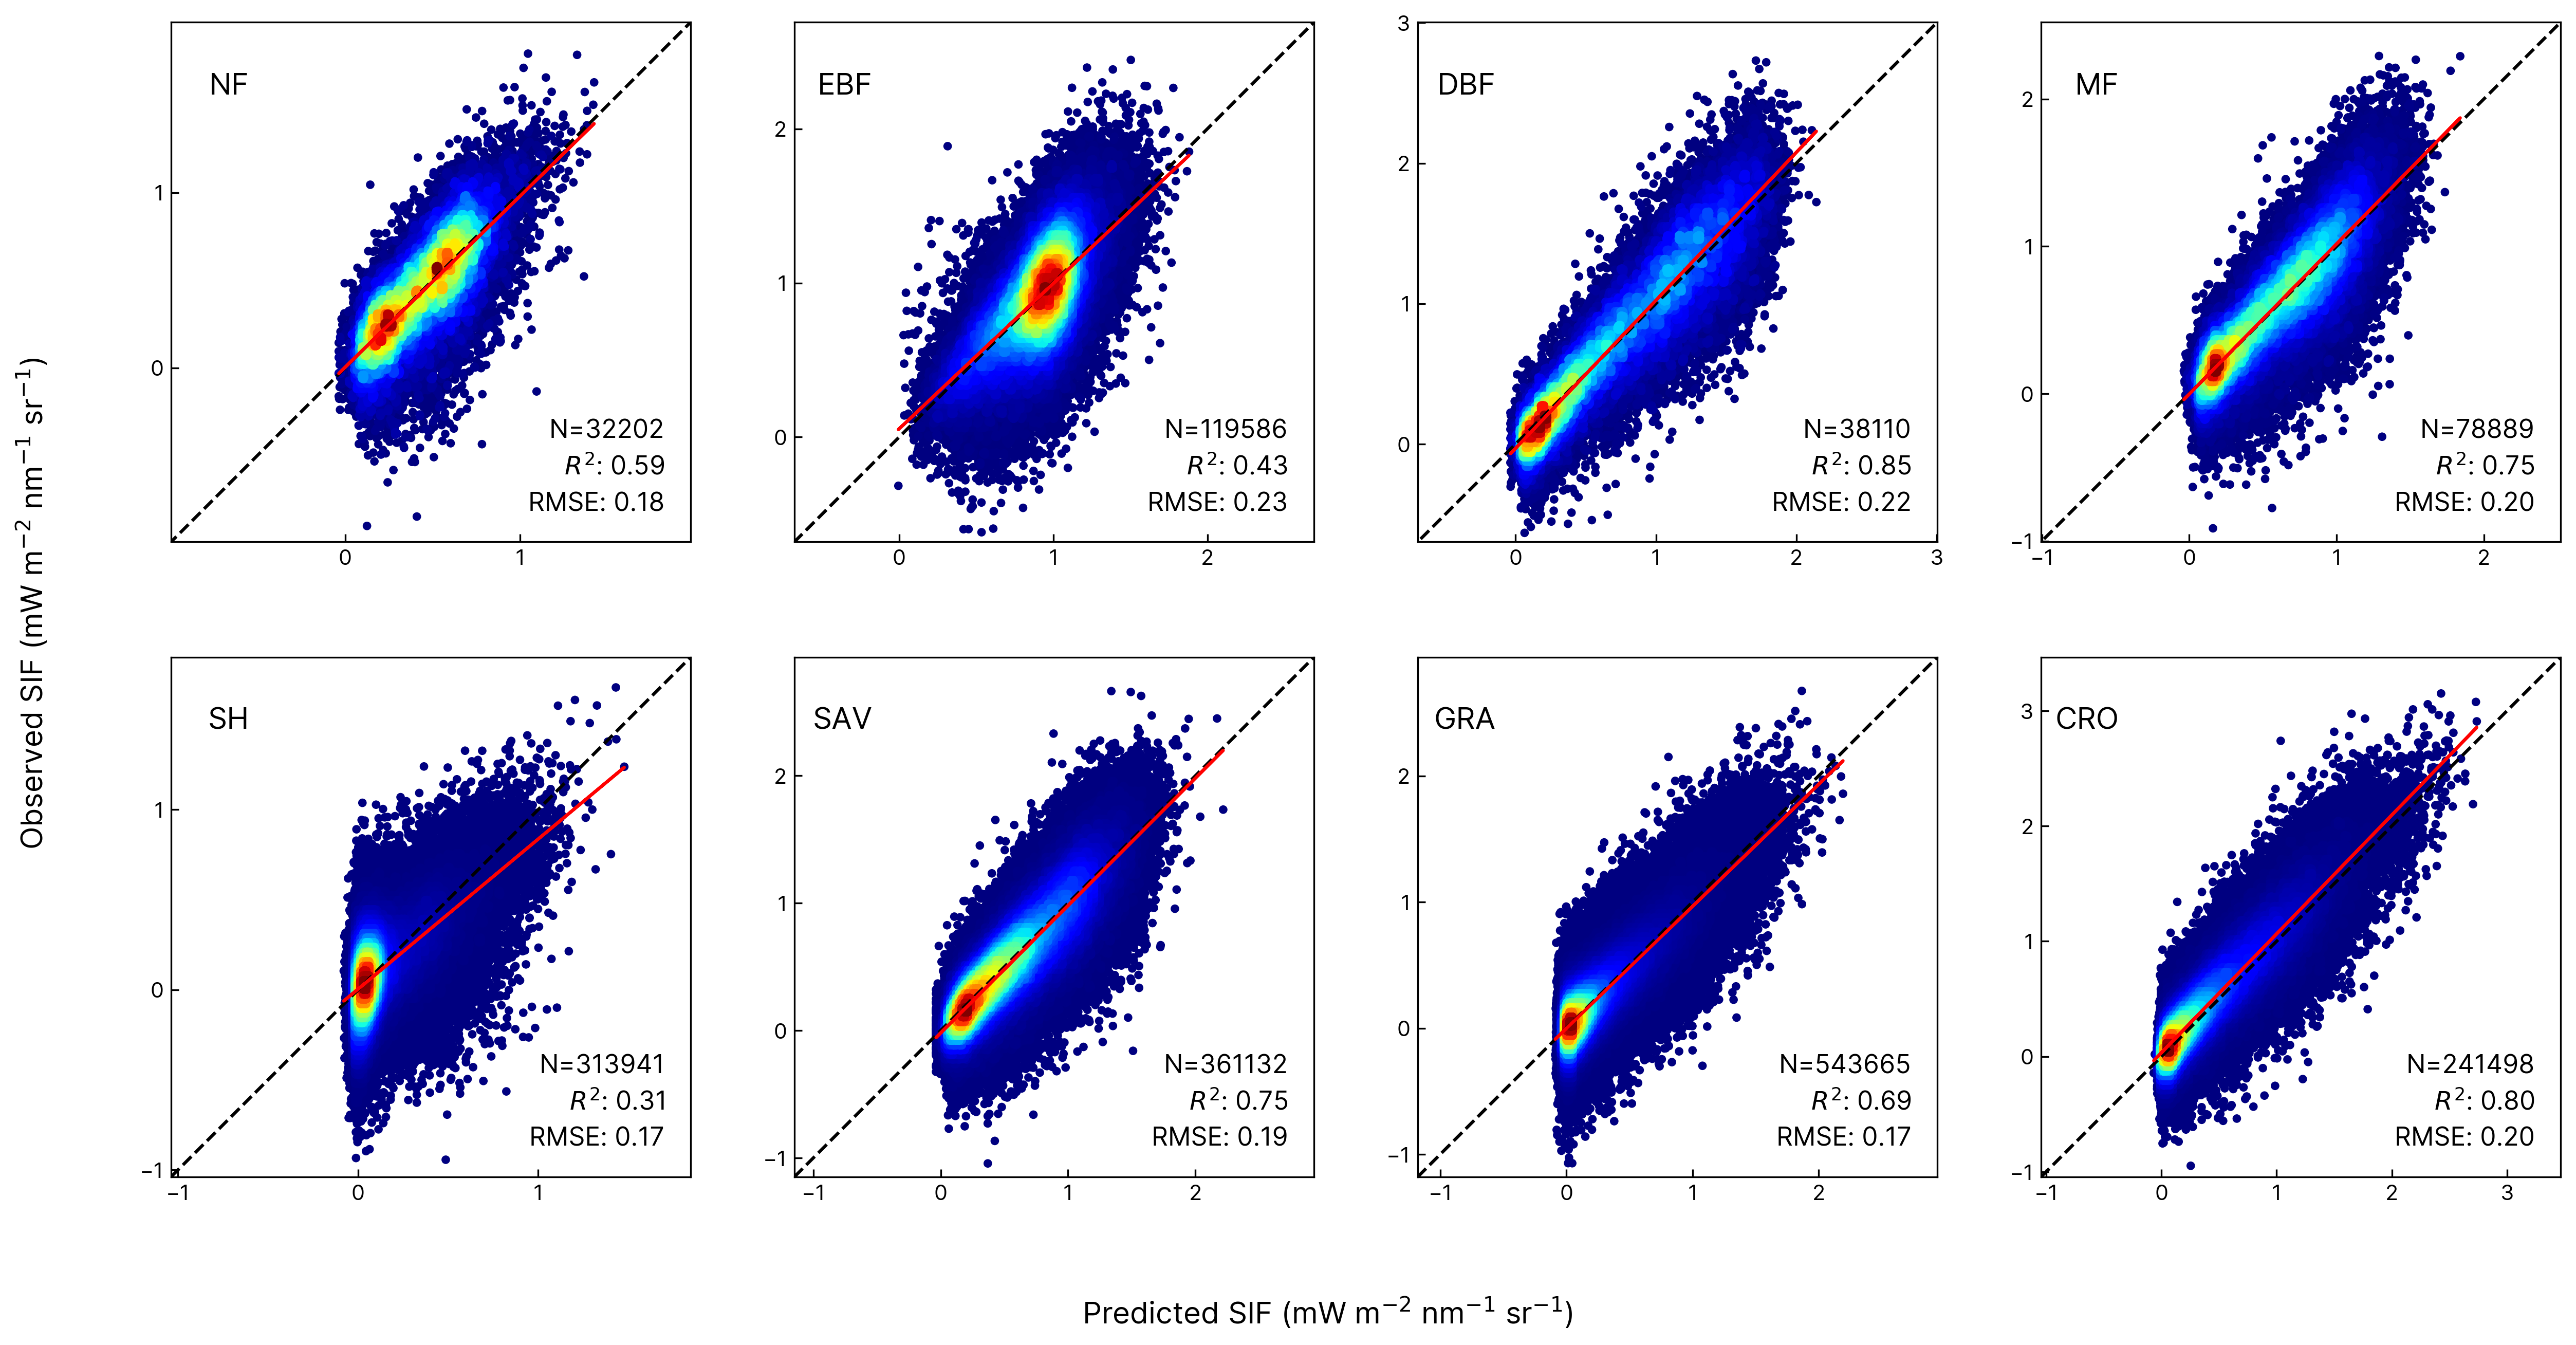

In [37]:
fig, axs=plt.subplots(2,4, figsize=(20,10), dpi=300)

ax=axs.flatten()
evaluate_performance(NF_test_ar_y, NF_test_predicted, ax[0], "NF")
evaluate_performance(EBF_test_ar_y, EBF_test_predicted, ax[1], "EBF")
evaluate_performance(DBF_test_ar_y, DBF_test_predicted, ax[2], "DBF")
evaluate_performance(MF_test_ar_y, MF_test_predicted, ax[3], "MF")
evaluate_performance(SH_test_ar_y, SH_test_predicted, ax[4], "SH")
evaluate_performance(SAV_test_ar_y, SAV_test_predicted, ax[5], "SAV")
evaluate_performance(GRA_test_ar_y, GRA_test_predicted, ax[6], "GRA")
evaluate_performance(CRO_test_ar_y, CRO_test_predicted, ax[7], "CRO")

fig.text(0.5, 0.04, 'Predicted SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, 'Observed SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig(os.path.join(fig_dir, model_name + "_test_igbp_shuffle.png"), dpi=300)

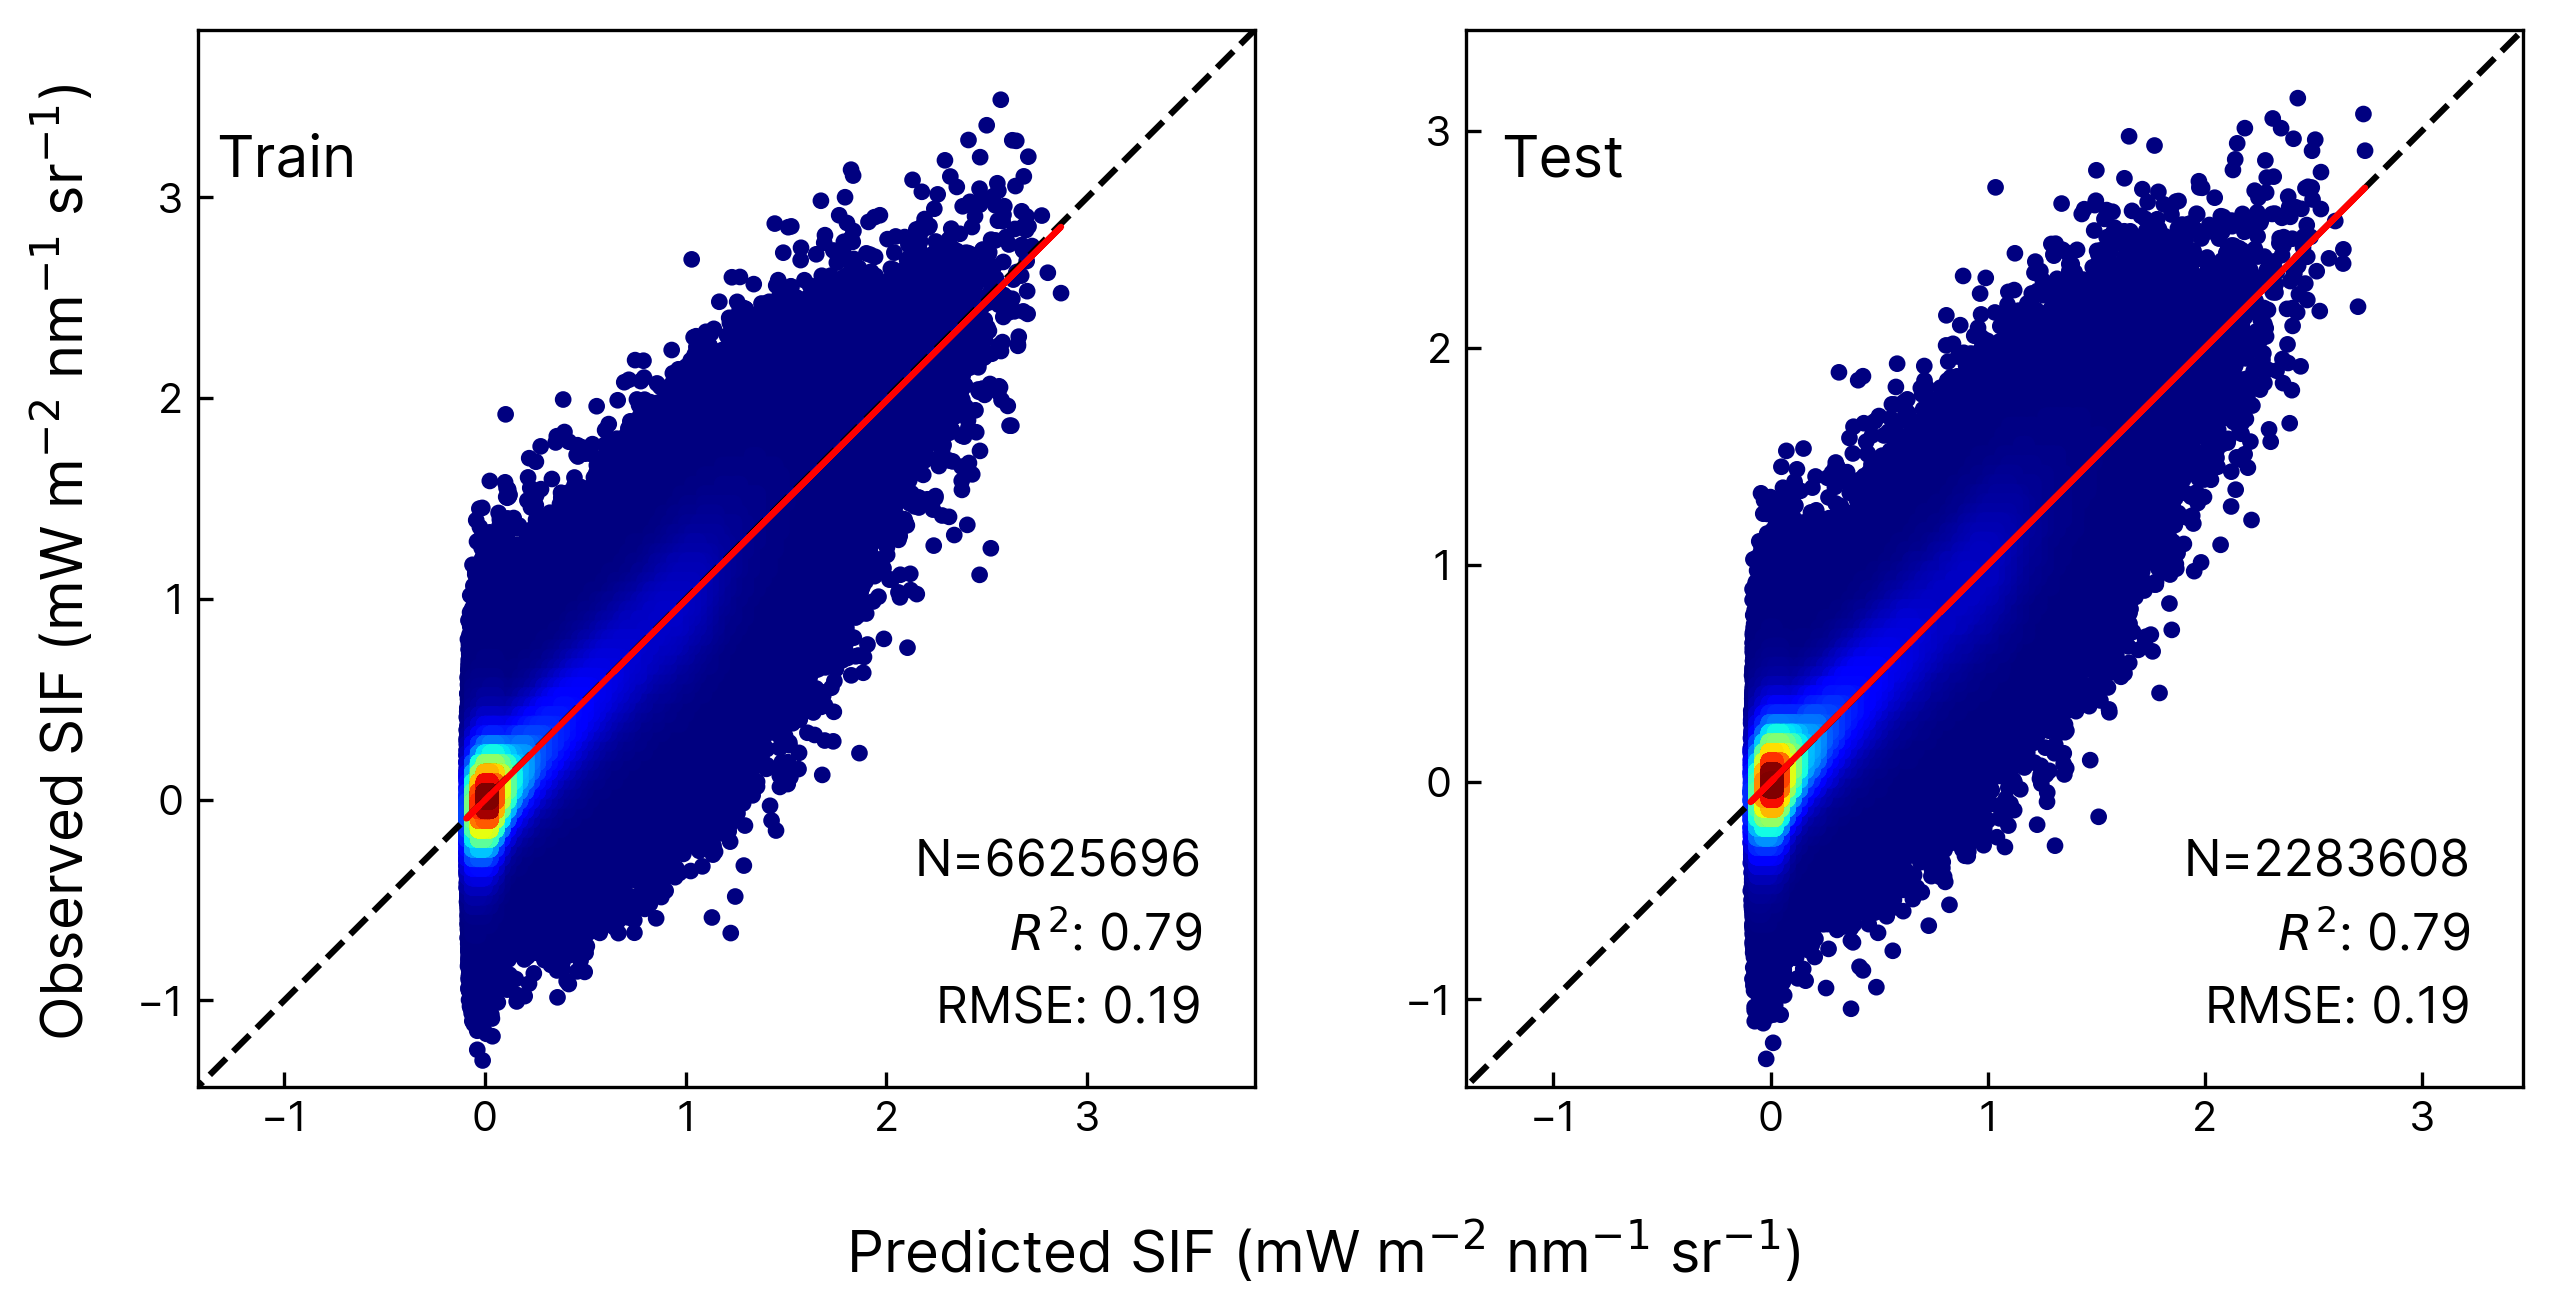

In [38]:
fig, axs=plt.subplots(1,2, figsize=(10,5), dpi=300)
ax=axs.flatten()
evaluate_performance(train_val_ar_y, predicted_train_val, ax[0], "Train")
evaluate_performance(test_ar_y, predicted_test, ax[1], "Test")

fig.text(0.5, 0.04, 'Predicted SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, 'Observed SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig(os.path.join(fig_dir, model_name + "train_test_together_shuffle.png"), dpi=300)